In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pykiwoom.kiwoom import *
import time
from datetime import datetime, timedelta

### 데이터 전처리

In [2]:
pref = pd.read_excel('pref_stk.xlsx')
comm = pd.read_excel('common_stk.xlsx')

Date_list = (comm['Unnamed: 0'][13:]).tolist()

pref_list = pref.iloc[8][1:]
find_comm = pref_list.map(lambda x: x[:-1] if x[-1] == '우' else x)
comm.columns = comm.iloc[8]

comm_set = set(comm.columns.tolist()[1:])
find_comm_set = set(find_comm.tolist())
comm_pref_include = list(find_comm_set - (find_comm_set - comm_set))

comm_close = comm[comm_pref_include]
comm_close = comm_close.iloc[13:]
comm_close.index = Date_list

pref.columns = pref.iloc[8]
pref_comm_include = list(map(lambda x : x + '우', comm_pref_include))
pref_close = pref[pref_comm_include]
pref_close = pref_close.iloc[13:]
pref_close.index = Date_list

comm_close = comm_close.dropna(axis=1)
pref_close = pref_close.dropna(axis=1)
pref_close.columns = list(map(lambda x : x[:-1], pref_close))
comm_close = comm_close[pref_close.columns.tolist()]

comm_close.columns = comm_close.columns.tolist()
pref_close.columns = pref_close.columns.tolist()

In [3]:
comm_stk_code = comm.iloc[7].map(lambda x: x[1:])[comm_close.columns.tolist()]
pref_stk_code = pref.iloc[7].map(lambda x: x[1:])[pref_comm_include]

comm_pref_code = pd.DataFrame()
comm_pref_code['보통주'] = comm_stk_code

pref_stk_code_revised = pref_stk_code.copy()
pref_stk_code_revised.index = pref_stk_code.index.map(lambda x: x[:-1])

comm_pref_code['우선주'] = pref_stk_code_revised

### api 로그인

In [4]:
# 로그인
kiwoom = Kiwoom()
kiwoom.CommConnect(block=True)

### 1차 선정 페어 정리

In [44]:
comm_curr_price = []
pref_curr_price = []

for comm_code, pref_code in zip(comm_pref_code['보통주'], comm_pref_code['우선주']) :
    tmp_comm_price = kiwoom.block_request("opt10001", 종목코드= comm_code,
                              output="주식기본정보요청", next=0)['현재가'][0]
                                
    tmp_pref_price = kiwoom.block_request("opt10001", 종목코드= pref_code,
                              output="주식기본정보요청", next=0)['현재가'][0]
                                
    comm_curr_price.append(tmp_comm_price)
    pref_curr_price.append(tmp_pref_price)
    
    print(tmp_comm_price)
    
    time.sleep(0.5)

+236500
115500
+758000
-63400
+61800
-33550
+247000
+28700
-59800
+42400
12650
+260000
+186000
+96600
-81400
+100500
224500
+66700
+834000
+16750
-30050
-78100
37850
-44350
1480000
+6190
+100500
-78700
-213500
-135000
214500
+93800
+99900
-162500
+98800
+271500
-98800
+43500
+27350
-49250
+54900
8990
+30350


In [45]:
comm_pref_code['보통주 현재가'] = comm_curr_price
comm_pref_code['우선주 현재가'] = pref_curr_price

comm_pref_code[['보통주 현재가', '우선주 현재가']] = comm_pref_code[['보통주 현재가', '우선주 현재가']].applymap(lambda x: int(x) * -1 if int(x) < 0 else x)
comm_pref_code[['보통주 현재가', '우선주 현재가']] = comm_pref_code[['보통주 현재가', '우선주 현재가']].applymap(lambda x: int(str(x)[1:]) if str(x)[0]== '+' else x)
comm_pref_code[['보통주 현재가', '우선주 현재가']] = comm_pref_code[['보통주 현재가', '우선주 현재가']].astype(int)

comm_pref_code['보통주/우선주(비율)'] = comm_pref_code['보통주 현재가'] / comm_pref_code['우선주 현재가']

### 시그널 생성

In [46]:
signal_1m = comm_pref_code['보통주/우선주(비율)']

In [47]:
#############################################
standard_date = '2021-07-26'
#############################################

standard_date_t = datetime.strptime(standard_date, '%Y-%m-%d')
standard_date_t_before5 = standard_date_t + timedelta(days=-7)
standard_date_before5 = datetime.strftime(standard_date_t_before5, '%Y-%m-%d')
standard_date_t_before = pd.date_range(standard_date_before5, standard_date, freq='B')[-2]
standard_date_before = datetime.strftime(standard_date_t_before, '%Y-%m-%d')

# 1. 보통주 / 우선주 비율
signal = comm_close / pref_close

# 2. 시그널 계산 (+1 시그마 및 -1 시그마)
# *** rolling의 계산법: 오늘 포함 20일 간의 값을 평균 혹은 표준편차를 구함
signal_pos = ( signal.rolling(20).mean() + signal.rolling(20).std() ).dropna()
signal_neg = ( signal.rolling(20).mean() - signal.rolling(20).std() ).dropna()

# 3. 보통주/우선주비율이 +1시그마 초과하는 페어 선정
# *** z-score 양수인 것만 선정 (개인 대주거래의 경우, 우선주 공매도 불가능하므로)

# 4. 전날 시그널 발생했던 페어의 경우 제외
# *** 잘 수렴하지 않는 상태의 페어일 확률이 높기 때문
signal_stk = signal_1m[(signal_1m > signal_pos.loc[standard_date]) ].sort_values()[::-1]
signal_stk_before = signal.loc[standard_date_before][(signal.loc[standard_date_before] 
                                        > signal_pos.loc[standard_date_before]) ].sort_values()[::-1]

tmp_set = set(signal_stk.index.tolist())
tmp_set_before = set(signal_stk_before.index.tolist())

pair_list = list(tmp_set - tmp_set_before)

final_signal_stk = signal_stk[pair_list]
final_signal_pos = signal_pos.loc[standard_date][pair_list]

sns.set_style('dark')
rc('font', family='Nanumgothic')
plt.rcParams['axes.unicode_minus'] = False

In [48]:
ratio_signal_df = pd.DataFrame()

# 괴리율 계산: [(보통주/우선주비율) - 1시그마] / (보통주/우선주비율) 
ratio_signal_df['보통주/우선주비율'] = final_signal_stk
ratio_signal_df['+1 시그마'] = final_signal_pos
ratio_signal_df['괴리율'] = (final_signal_stk - final_signal_pos) / final_signal_stk
ratio_signal_df = ratio_signal_df.applymap(lambda x: round(x,4))
ratio_signal_df.sort_values('괴리율')[::-1]

,보통주/우선주비율,+1 시그마,괴리율
8,,,
삼성전기,1.7714,1.7480,0.0132
대한항공,0.7569,0.7516,0.0069
S-Oil,1.7273,1.7158,0.0066
SK케미칼,2.3084,2.3024,0.0026
아모레G,2.6057,2.5991,0.0025


In [49]:
# 비율 plot

def ratio_make(date, pair) :
    ratio_df = pd.DataFrame()
    ratio_df[pair + '-' + pair + '우'] = signal[pair].loc[date:]

    return ratio_df

In [50]:
# 시그널 plot

def signal_make(date, pair) :
    signal_df = pd.DataFrame()

    signal_df[pair + '-' + pair + '우'] = signal[pair].loc[date:]
    signal_df['+1 시그마'] = signal_pos[pair].loc[date:]
    signal_df['-1 시그마'] = signal_neg[pair].loc[date:]

    return signal_df

In [51]:
# pair 종가 데이터프레임 만들기
def pair_close(pair) :
    pair_close_df = pd.DataFrame()
    pair_close_df[pair] = comm_close[pair].loc['2021-05':]
    pair_close_df[pair + '우'] = pref_close[pair].loc['2021-05':]
    
    return pair_close_df

In [52]:
# 각종 수량 및 대금 계산
# 보통주 갯수 증가에 따른 우선주 수량/ 종가 / 보통-우선비율/ 매수매도수량 / 실제우선주매수수량 / 매수매도대금 

def calcul_amount(pair) : 
    print('[' + pair + ']')
    print('')
    p_com_close = comm_pref_code.loc[pair]['보통주 현재가']
    p_pref_close = comm_pref_code.loc[pair]['우선주 현재가']

    print('보통주 갯수 증가에 따른 우선주 수량 계산')
    
    rest = []
    for i in range(1, 11) : 
        
        print('보통주', i, '->','우선주',(p_com_close / p_pref_close) * i)
        rest.append((p_com_close / p_pref_close) * i % 1)
        
        if i == 10 and (p_com_close / p_pref_close * i) < 1 :
            for i in range(11, 21) :
                print('보통주', i, '->','우선주',(p_com_close / p_pref_close) * i)
                rest.append((p_com_close / p_pref_close) * i % 1)            
    print('')

    p_com_amount = pd.Series(rest).idxmin() + 1
    p_pref_amount = int((p_com_close / p_pref_close) * p_com_amount)
    p_pref_real_amount = (p_com_close / p_pref_close) * p_com_amount

    print(pair + '우' + ' (실제)'+ ': ' + str(p_pref_real_amount) + '주 매수')


In [53]:
# 대금계산
def calcul_buy_sell(pair) : 
    p_com_close = comm_pref_code.loc[pair]['보통주 현재가']
    p_pref_close = comm_pref_code.loc[pair]['우선주 현재가']

    rest = []
    for i in range(1, 11) : 
        rest.append((p_com_close / p_pref_close) * i % 1)
                
    p_com_amount = pd.Series(rest).idxmin() + 1
    p_pref_amount = int((p_com_close / p_pref_close) * p_com_amount)
    p_pref_real_amount = (p_com_close / p_pref_close) * p_com_amount
    
    sell_total = p_com_close * p_com_amount
    buy_total = p_pref_close * p_pref_amount
    buy_sell_total = buy_total + sell_total
    
    return [p_com_close, p_pref_close, p_com_amount, p_pref_amount, sell_total, buy_total, buy_sell_total]

In [54]:
def calcul_opt_same_buy_sell(pair_list_) : 
    
    buy_sell_df_ = pd.DataFrame()
    for pair in pair_list_ :
        tmp_list = calcul_buy_sell(pair)
        buy_sell_df_[pair] = tmp_list
        buy_sell_df_.index = ['보통주종가', '우선주종가', '보통주매도수량', '우선주매입수량', 
                              '매도대금', '매수대금', '매수매도대금합']

    
    drop_idx = buy_sell_df_.loc['우선주매입수량'][buy_sell_df_.loc['우선주매입수량']  == 0].index
    drop_idx2 = buy_sell_df_.loc['보통주매도수량'][buy_sell_df_.loc['보통주매도수량']  == 0].index
    
    final_pair_series = buy_sell_df_.loc['매수매도대금합'][buy_sell_df_.loc['매수매도대금합'] < 3000000]
    final_pair_series = final_pair_series.drop(drop_idx)
    final_pair_series = final_pair_series.drop(drop_idx2)
    
    final_pair_idx = final_pair_series.index.tolist()
    final_pair_val = final_pair_series.values.tolist()
    
    buy_sell_x = []

    for pair_, buy_sell in zip(final_pair_idx, final_pair_val) :
        buy_sell_x.append(max(final_pair_series) / buy_sell)

    buy_sell_x_round = list(map(lambda x: int(round(x)), buy_sell_x))
    opt_buy_sell_df_ = (buy_sell_df_[final_pair_idx] * buy_sell_x_round).loc[['보통주매도수량', '우선주매입수량', 
                              '매도대금', '매수대금', '매수매도대금합']]
    
    return buy_sell_df_.T, opt_buy_sell_df_.T,final_pair_idx

In [55]:
def calcul_amount_tmp(com_price, pref_price) :
    rest_ = []
    for i in range(1, 11) : 
        
        print('보통주', i, '->','우선주',(com_price / pref_price) * i)
        rest_.append((com_price / pref_price) * i % 1)
        
    com_amount = pd.Series(rest_).idxmin() + 1
    pref_amount = int((com_price / pref_price) * com_amount)
    pref_real_amount = (com_price / pref_price) * com_amount
    
    print('')
    print('보통주 : ' + str(com_amount) + '주 매도')
    print('우선주' + ': ' + str(pref_amount) + '주 매수')
    print('우선주' + ' (실제)'+ ': ' + str(pref_real_amount) + '주 매수')

In [56]:
def plot_type(date, type_, pair_list) :
    
    if type_ == 'ratio' :
        for pair in pair_list :
            ratio_make(signal_start, pair).plot(figsize = (16,4))
            plt.legend(loc = 'upper left')

    elif type_ == 'signal' :
        for pair in pair_list :
            signal_make(signal_start, pair).plot(figsize = (16,4))
            plt.legend(loc = 'upper left')

    elif type_ == 'pair_cummret' :
        for pair in pair_list :
            pair_close(pair).pct_change().add(1).cumprod().plot()
            plt.legend(loc = 'upper left')
            
    elif type_ == 'amount' :
        for pair in pair_list :
            calcul_amount(pair)
            print('-----------------------------------------------------------------')
            print('')

    elif type_ == 'stat' :
        for pair in pair_list :
            print_stat(pair)
            print('-----------------------------------------------------------------')
            print('')
    
    elif type_ =='moniter_ratio':
        for pair in pair_list :
            ratio_m1(pair)
            
    elif type_ =='moniter_signal':
        for pair in pair_list :
            signal_make(moniter_start, pair).plot(figsize = (16,4))
            plt.axvline(x=standard_date_t, label = '시그널발생날짜', color='r', linestyle='--', linewidth=3)
            plt.axvline(x=standard_date_t + timedelta(days=1), label = '투자진입날짜', color='b', linestyle='--', linewidth=3)
            plt.legend(loc = 'upper left')
            
    elif type_ =='moniter_pair_cummret':
        for pair in pair_list :
            pair_close(pair).loc[moniter_start:].pct_change().add(1).cumprod().plot()
            plt.axvline(x=standard_date_t, label = '시그널발생날짜', color='r', linestyle='--', linewidth=3)
            plt.axvline(x=standard_date_t + timedelta(days=1), label = '투자진입날짜', color='b', linestyle='--', linewidth=3)
            plt.legend(loc = 'upper left')
        
    else :
        print('잘못된 입력입니다!!')

### 보통주/우선주 비율 시그널

In [57]:
signal_start = '2019'

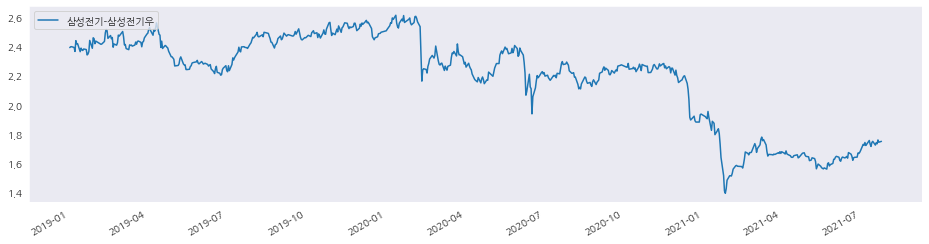

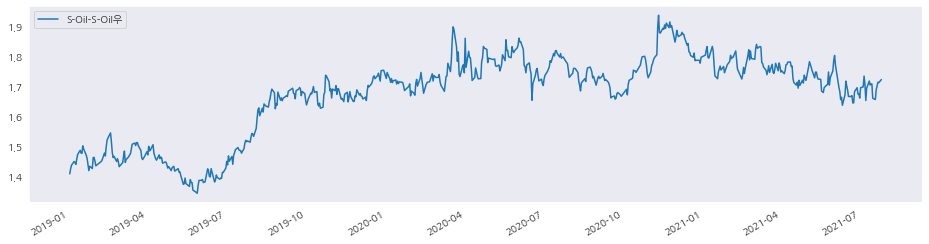

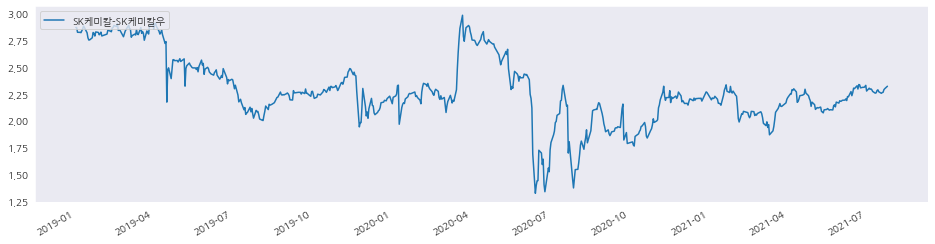

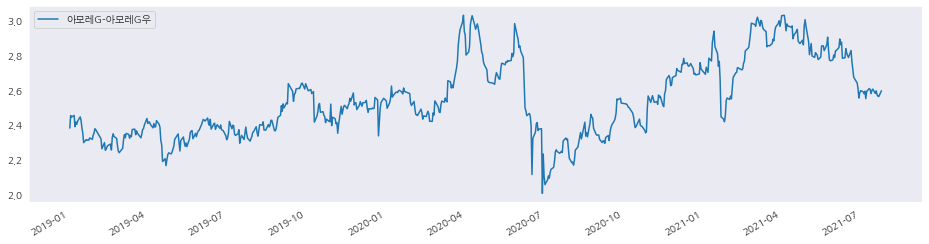

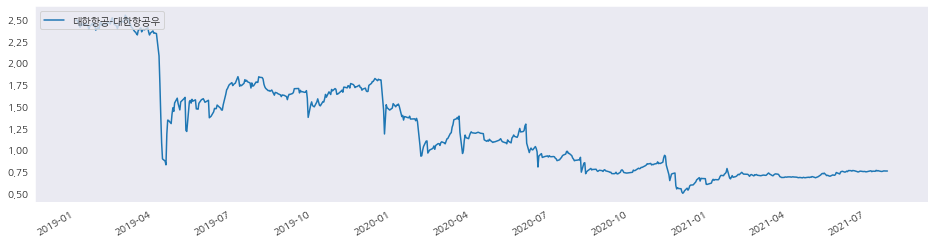

In [58]:
plot_type(signal_start, 'ratio', pair_list)

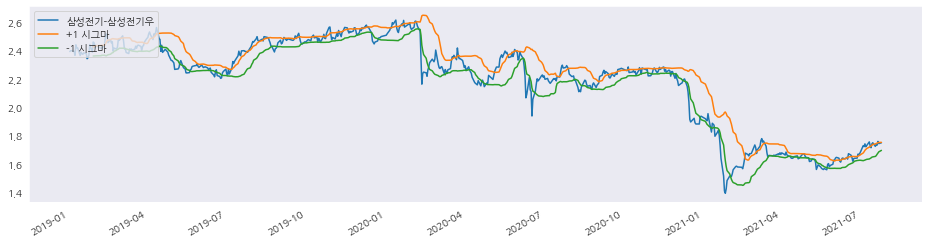

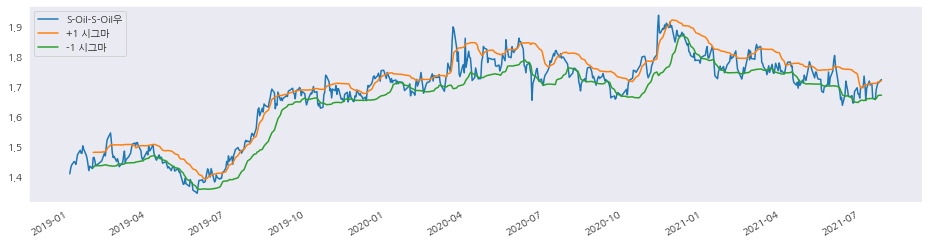

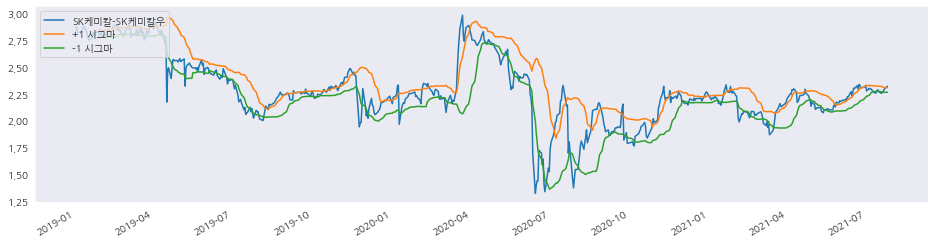

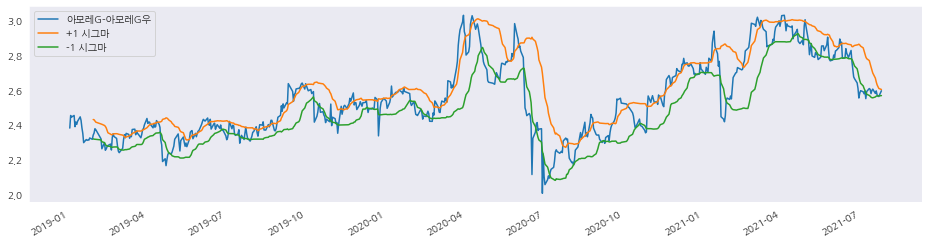

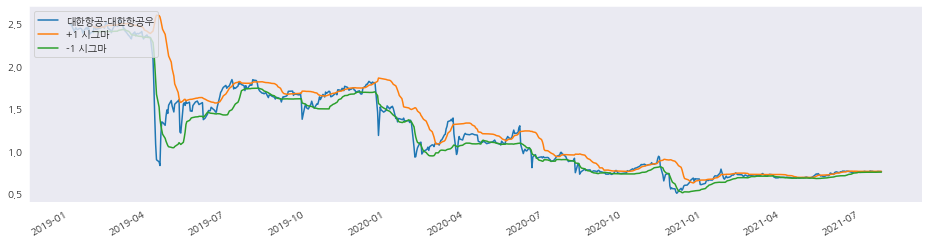

In [59]:
plot_type(signal_start, 'signal',pair_list)

### 최근 누적수익률 비교

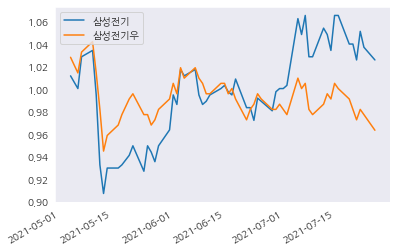

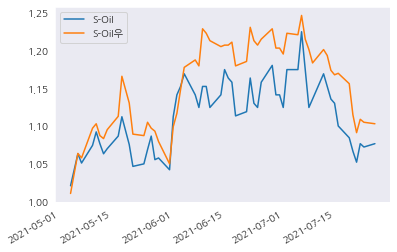

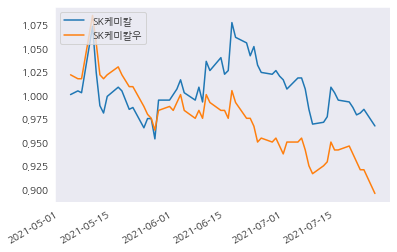

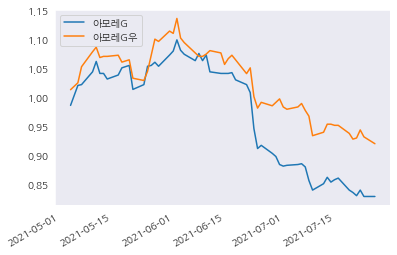

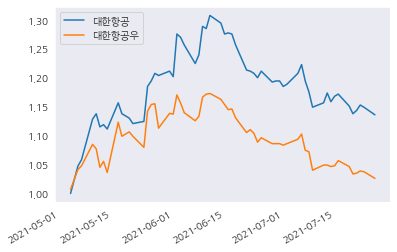

In [60]:
plot_type(np.nan, 'pair_cummret',pair_list)

### +1시그마 초과로 선정된 페어

In [61]:
final_signal_stk

8
삼성전기     1.771429
S-Oil    1.727273
SK케미칼    2.308411
아모레G     2.605664
대한항공     0.756858
Name: 보통주/우선주(비율), dtype: float64

In [62]:
plot_type(np.nan, 'amount', pair_list)

[삼성전기]

보통주 갯수 증가에 따른 우선주 수량 계산
보통주 1 -> 우선주 1.7714285714285714
보통주 2 -> 우선주 3.5428571428571427
보통주 3 -> 우선주 5.314285714285714
보통주 4 -> 우선주 7.085714285714285
보통주 5 -> 우선주 8.857142857142858
보통주 6 -> 우선주 10.628571428571428
보통주 7 -> 우선주 12.399999999999999
보통주 8 -> 우선주 14.17142857142857
보통주 9 -> 우선주 15.942857142857143
보통주 10 -> 우선주 17.714285714285715

삼성전기우 (실제): 7.085714285714285주 매수
-----------------------------------------------------------------

[S-Oil]

보통주 갯수 증가에 따른 우선주 수량 계산
보통주 1 -> 우선주 1.7272727272727273
보통주 2 -> 우선주 3.4545454545454546
보통주 3 -> 우선주 5.181818181818182
보통주 4 -> 우선주 6.909090909090909
보통주 5 -> 우선주 8.636363636363637
보통주 6 -> 우선주 10.363636363636363
보통주 7 -> 우선주 12.090909090909092
보통주 8 -> 우선주 13.818181818181818
보통주 9 -> 우선주 15.545454545454545
보통주 10 -> 우선주 17.272727272727273

S-Oil우 (실제): 12.090909090909092주 매수
-----------------------------------------------------------------

[SK케미칼]

보통주 갯수 증가에 따른 우선주 수량 계산
보통주 1 -> 우선주 2.308411214953271
보통주 2 -> 우선주 4.616822429906542

In [63]:
buy_sell_df, opt_buy_sell_df, final_pair = calcul_opt_same_buy_sell(pair_list)

In [64]:
final_stat_df = ratio_signal_df.loc[final_pair].sort_values('괴리율')[::-1]

In [65]:
final_stat_df

,보통주/우선주비율,+1 시그마,괴리율
8,,,
삼성전기,1.7714,1.7480,0.0132
대한항공,0.7569,0.7516,0.0069
S-Oil,1.7273,1.7158,0.0066
아모레G,2.6057,2.5991,0.0025


In [82]:
186000 / 105000

1.7714285714285714

In [66]:
# 대한항공
30400 / 40100

0.7581047381546134

In [67]:
30350 / 40100

0.756857855361596

In [68]:
# s-oil
98600 / 57200

1.7237762237762237

In [85]:
# 삼성전기
186000/105500

1.7630331753554502

In [69]:
opt_buy_sell_df

,보통주매도수량,우선주매입수량,매도대금,매수대금,매수매도대금합
삼성전기,4,7,744000,735000,1479000
S-Oil,7,12,691600,686400,1378000
아모레G,10,26,598000,596700,1194700
대한항공,24,18,728400,721800,1450200


In [70]:
buy_sell_df.loc[final_stat_df.index]

,보통주종가,우선주종가,보통주매도수량,우선주매입수량,매도대금,매수대금,매수매도대금합
8,,,,,,,
삼성전기,186000,105000,4,7,744000,735000,1479000
대한항공,30350,40100,4,3,121400,120300,241700
S-Oil,98800,57200,7,12,691600,686400,1378000
아모레G,59800,22950,5,13,299000,298350,597350


In [71]:
opt_buy_sell_df.loc[final_stat_df.index]

,보통주매도수량,우선주매입수량,매도대금,매수대금,매수매도대금합
8,,,,,
삼성전기,4,7,744000,735000,1479000
대한항공,24,18,728400,721800,1450200
S-Oil,7,12,691600,686400,1378000
아모레G,10,26,598000,596700,1194700


### 최적 매수매도수량 임시 계산

In [72]:
calcul_amount_tmp(108500, 46950)

보통주 1 -> 우선주 2.3109691160809374
보통주 2 -> 우선주 4.621938232161875
보통주 3 -> 우선주 6.9329073482428125
보통주 4 -> 우선주 9.24387646432375
보통주 5 -> 우선주 11.554845580404686
보통주 6 -> 우선주 13.865814696485625
보통주 7 -> 우선주 16.176783812566562
보통주 8 -> 우선주 18.4877529286475
보통주 9 -> 우선주 20.798722044728436
보통주 10 -> 우선주 23.109691160809373

보통주 : 10주 매도
우선주: 23주 매수
우선주 (실제): 23.109691160809373주 매수


### 익/손절 기준 계산
    데이터 계산 날짜 기준(총20일): 시그널 발생 날짜 19일 전 ~ 시그널 발생날짜 까지 (영업일 기준)

In [73]:
def profit_loss_cut(pair):
    
    tmp_signal_df = signal_make(signal_start, pair)[:standard_date]

    trade_start_sig = tmp_signal_df.loc[standard_date]

    mean = tmp_signal_df.iloc[-20:].mean()
    std = tmp_signal_df.iloc[-20:].std()

    profit_cut_ = mean[0] + std[0] * 0.5
    loss_cut_ = mean[0] + std[0] * 3
    
    return (float(profit_cut_), float(loss_cut_))

In [74]:
def print_stat(pair):
    
    tmp_signal_df = signal_make(signal_start, pair)[:standard_date]

    trade_start_sig = tmp_signal_df.loc[standard_date]

    mean = tmp_signal_df.iloc[-20:].mean()
    std = tmp_signal_df.iloc[-20:].std()

    profit_cut_ = mean[0] + std[0] * 0.5
    loss_cut_ = mean[0] + std[0] * 3
    
    print('[' + pair + '-' + pair +'우]')
    print('')
    print('시그널 발생 당시 보통주/우선주 비율:', round(float(trade_start_sig[0]),3))
    print('시그널 발생 당시 +1시그마:', round(trade_start_sig[1],3))
    print('시그널 발생 당시 -1시그마:', round(trade_start_sig[2],3))
    print('')
    print('(보통주/우선주비율 기준)')
    print('익절 기준:', round(float(profit_cut_),3))
    print('손절 기준:', round(float(loss_cut_),3))

In [75]:
plot_type(np.nan, 'stat', pair_list)

[삼성전기-삼성전기우]

시그널 발생 당시 보통주/우선주 비율: 1.745
시그널 발생 당시 +1시그마: 1.748
시그널 발생 당시 -1시그마: 1.691

(보통주/우선주비율 기준)
익절 기준: 1.734
손절 기준: 1.805
-----------------------------------------------------------------

[S-Oil-S-Oil우]

시그널 발생 당시 보통주/우선주 비율: 1.721
시그널 발생 당시 +1시그마: 1.716
시그널 발생 당시 -1시그마: 1.668

(보통주/우선주비율 기준)
익절 기준: 1.704
손절 기준: 1.763
-----------------------------------------------------------------

[SK케미칼-SK케미칼우]

시그널 발생 당시 보통주/우선주 비율: 2.315
시그널 발생 당시 +1시그마: 2.302
시그널 발생 당시 -1시그마: 2.258

(보통주/우선주비율 기준)
익절 기준: 2.291
손절 기준: 2.347
-----------------------------------------------------------------

[아모레G-아모레G우]

시그널 발생 당시 보통주/우선주 비율: 2.592
시그널 발생 당시 +1시그마: 2.599
시그널 발생 당시 -1시그마: 2.564

(보통주/우선주비율 기준)
익절 기준: 2.59
손절 기준: 2.634
-----------------------------------------------------------------

[대한항공-대한항공우]

시그널 발생 당시 보통주/우선주 비율: 0.749
시그널 발생 당시 +1시그마: 0.752
시그널 발생 당시 -1시그마: 0.743

(보통주/우선주비율 기준)
익절 기준: 0.749
손절 기준: 0.761
-----------------------------------------------------------------



### (보통주/우선주비율) 모니터링

In [76]:
moniter_start = standard_date_t + timedelta(days=-1)

### 1분봉 크롤링

In [77]:
def craw_1m(stk_code) :
    # TR 요청 (연속조회)
    dfs = []
    df = kiwoom.block_request("opt10080", 종목코드=stk_code, 틱범위 = 1,  수정주가구분=1,
                              output="주식분봉차트조회", next=0)

    dfs.append(df)

    last_date = df['체결시간'].map(lambda x : datetime.strptime(x, '%Y%m%d%H%M%S'))
    last_date = last_date.reset_index()['체결시간'].iloc[-1]
    
    # 모니터링 시작하는 날짜를 가져올때 까지 반복
    while last_date > moniter_start:
        df = kiwoom.block_request("opt10080", 종목코드=stk_code, 틱범위 = 1,  수정주가구분=1,
                                  output="주식분봉차트조회", next=2)
        
        last_date = df['체결시간'].map(lambda x : datetime.strptime(x, '%Y%m%d%H%M%S'))
        last_date = last_date.reset_index()['체결시간'].iloc[-1]
        
        dfs.append(df)
        time.sleep(1)

    df = pd.concat(dfs)
    
    return df

In [78]:
def cleansing_1m(stk_code_) :
    tmp_df = craw_1m(stk_code_)
    tmp_df['현재가']  = tmp_df['현재가'] .map(lambda x: int(x) * -1 if int(x) < 0 else int(x))
    tmp_df['현재가'] = tmp_df['현재가'].map(lambda x: int(str(x)[1:]) if str(x)[0] == '+' else int(x))
    tmp_df['체결시간'] = tmp_df['체결시간'].map(lambda x : datetime.strptime(x, '%Y%m%d%H%M%S'))
    tmp_df = tmp_df[['현재가','체결시간']]
    tmp_df = tmp_df.set_index('체결시간')
    
    return tmp_df

In [79]:
def monitering_plot(date, pair) :

    moniter_df = ratio_make(date, pair)

    moniter_df['익절기준'] = profit_loss_cut(pair)[0]
    moniter_df['손절기준'] = profit_loss_cut(pair)[1]

    moniter_df.plot(figsize = (16,4))
    plt.axvline(x=standard_date_t, label = '시그널발생날짜', color='r', linestyle='--', linewidth=3)
    plt.axvline(x=standard_date_t + timedelta(days=1), label = '투자진입날짜', color='b', linestyle='--', linewidth=3)
    plt.legend(loc = 'upper left')

In [80]:
def ratio_m1(pair_name) :

    comm_code = comm_stk_code[pair_name]
    pref_code = pref_stk_code[pair_name + '우']

    comm_close_m1 = cleansing_1m(comm_stk_code[pair_name])
    pref_close_m1 = cleansing_1m(pref_stk_code[pair_name + '우'])

    close_m1 = pd.concat([comm_close_m1, pref_close_m1], axis =1).dropna()
    close_m1.columns = [pair_name, pair_name + '우']
    close_m1 = close_m1.astype(int)
    close_m1[pair_name + '-' + pair_name + '우'] = close_m1[pair_name] / close_m1[pair_name + '우']

    ratio_m1 = pd.DataFrame(close_m1[pair_name + '-' + pair_name + '우'])
    ratio_m1['익절기준'] = profit_loss_cut(pair_name)[0]
    ratio_m1['손절기준'] = profit_loss_cut(pair_name)[1]

    ratio_m1.plot(figsize = (16,4))
    plt.axvline(x=standard_date_t, label = '시그널발생날짜', color='r', linestyle='--', linewidth=3)
    plt.axvline(x=standard_date_t + timedelta(days=1), label = '투자진입날짜', color='b', linestyle='--', linewidth=3)
    plt.legend(loc = 'upper left')

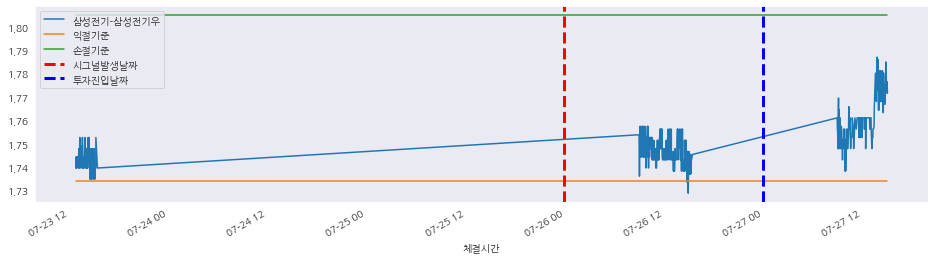

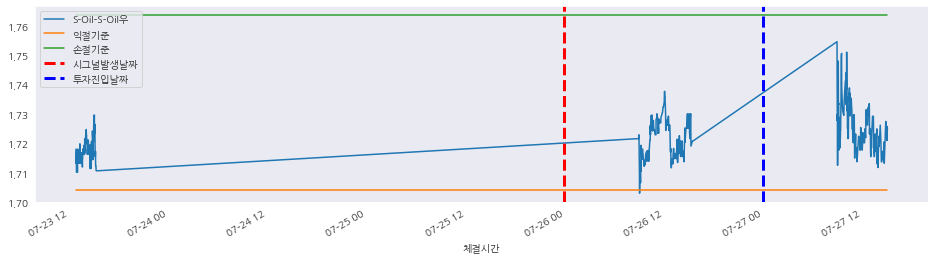

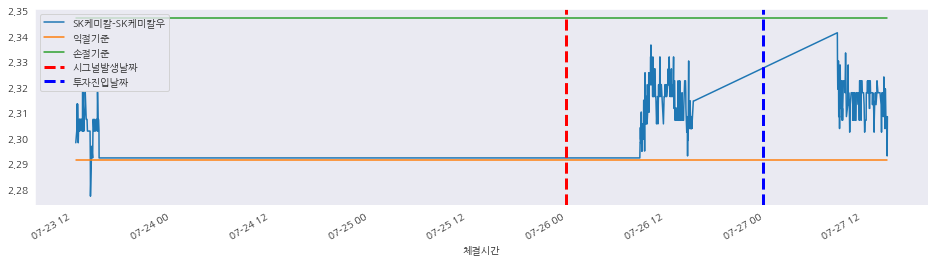

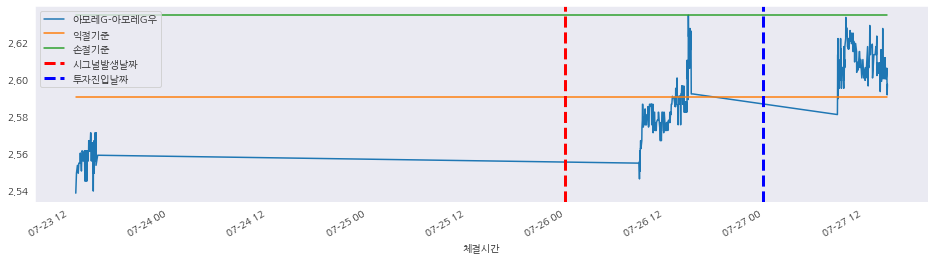

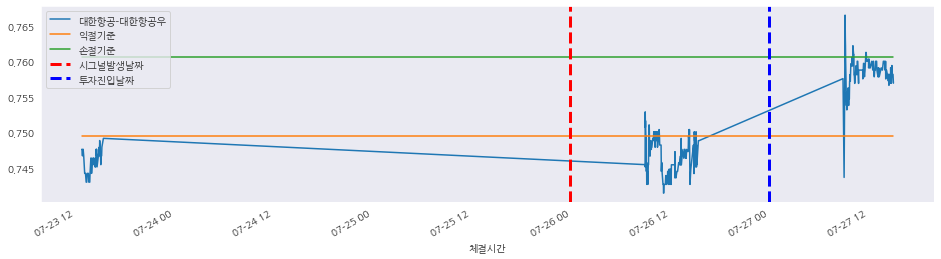

In [81]:
plot_type(moniter_start, 'moniter_ratio', pair_list)